Выполнял Достовалов Максим

In [420]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy import stats
from scipy import special

import warnings
warnings.filterwarnings("ignore")

In [421]:
data = pd.read_excel('pdn_hse_with_flags.xlsx')

data.head()

,ID loan,ID client,LoanSum,LoanTerm,pdn,FPD10,FPD30,NPL10,NPL30,old_user
0,1,1000,6000,25,11862.10,0,0,0,0,0
1,2,1001,9900,30,70.48,0,0,0,0,1
2,3,1002,9900,30,58.60,0,0,0,0,1
3,4,1003,5000,25,679.65,1,0,1,1,0
4,5,1004,6000,20,875.48,1,1,1,1,0


# Предобработка данных

<Axes: xlabel='pdn', ylabel='Density'>

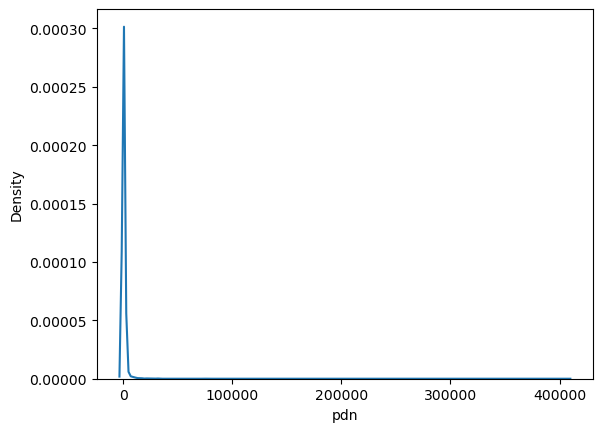

In [422]:
sns.kdeplot(data.pdn)

В исследовании переменная "pdn" демонстрирует наличие значительных выбросов, что усложняет её аналитическую обработку в первоначальном виде. Для целей данного анализа, наблюдения с значениями превышающими 10,000 будут классифицированы как выбросы.

В связи с этим, для стабилизации дисперсии и уменьшения асимметрии распределения, а также для приближения его формы к нормальному распределению, будет применено преобразование Бокса-Кокса к данной переменной. Это преобразование целенаправленно используется для обработки данных, подверженных сильным искажениям, и является методологически обоснованным подходом к решению подобных проблем анализа данных.

In [423]:
print(f'Количество удалённых выбросов: {(data.pdn > 10000).sum()}')

Количество удалённых выбросов: 46



      lambda_pdn=-0.032
это параметр преобразования, который подбирается автоматически таким образом, чтобы максимизировать логарифмическое правдоподобие нормального распределения преобразованных данных.

Согласно тесту Шапиро-Уилка (p_value=0.0002), распределение pdn всё ещё не яваляется нормальным, но проведение статистических тестов по преобразованной переменной считается более адекватным подходом по сравнению с анализом исходных данных



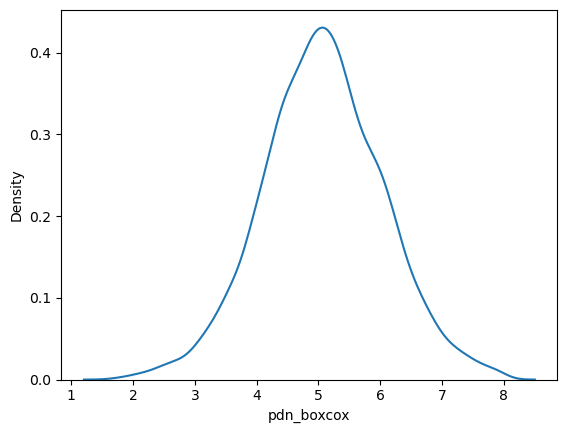

In [424]:
data = data[data.pdn < 10000]
data['pdn_boxcox'], lambda_pdn = stats.boxcox(data.pdn)
sns.kdeplot(data.pdn_boxcox)

print(f'''
      {lambda_pdn=:.3f}
это параметр преобразования, который подбирается автоматически таким образом, чтобы максимизировать логарифмическое правдоподобие нормального распределения преобразованных данных.

Согласно тесту Шапиро-Уилка (p_value={stats.shapiro(data.pdn_boxcox)[1]:.4f}), распределение pdn всё ещё не яваляется нормальным, но проведение статистических тестов по преобразованной переменной считается более адекватным подходом по сравнению с анализом исходных данных
''')

Те же преобразования провелись и с переменной LoanSum в связи с её асимметрией

<Axes: xlabel='LoanSum_boxcox', ylabel='Density'>

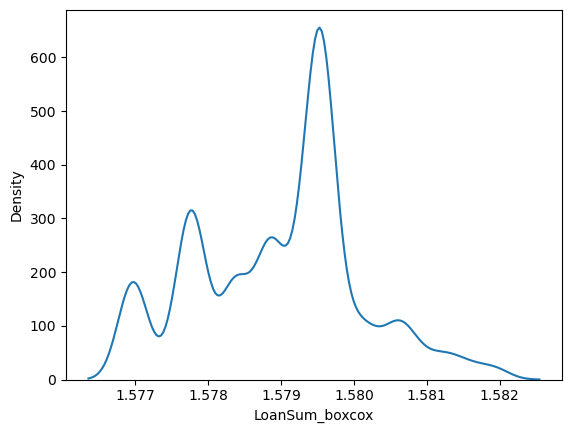

In [425]:
data['LoanSum_boxcox'], lambda_LoanSum = stats.boxcox(data.LoanSum)

sns.kdeplot(data.LoanSum_boxcox)

`Примечание`: Переменная LoanSum обладает уникальными характеристиками, проявляющимися в её одновременном сходстве с дискретными и непрерывными переменными. Это связано с тем, что заемщики склонны выбирать кредиты на "круглые" суммы, предпочитая целые и визуально привлекательные числа. В то время как выбор кредита на сумму, например, 11 375 рублей, может встречаться реже. Большинство предпочтений склоняется к суммам вроде 11 500 рублей, хотя вариации типа 11 375 рублей также возможны.

Следовательно, применение преобразования Бокса-Кокса может оказаться неподходящим и порождать амбивалентные результаты. Таким образом, использование переменной, модифицированной данным преобразованием, потребует осторожности и ограничится ситуациями, где оно обеспечивает заметное улучшение результатов.

# Анализ

### Регрессионный анализ. Регрессант - pdn

`Гипотеза`: возможно построить значимую регрессию на соотношение долга к доходу по всем имеющимся переменным

`Пометка`: 
- для правильной интерпретации моделей в дальнейшем будут использоваться робастные оценки дисперсии оценок (HC3)
- все коэффициенты будут интерпретироваться с учетом уровня значимости 5%

#### Простейшая модель для интерпретации

In [426]:
model = smf.ols(data=data, formula='pdn ~ LoanSum*old_user + LoanTerm + FPD10 + NPL10 + NPL30').fit(cov_type='HC3')

print(model.summary2())

                    Results: Ordinary least squares
Model:                OLS               Adj. R-squared:      0.067     
Dependent Variable:   pdn               AIC:                 86921.1123
Date:                 2024-03-14 11:56  BIC:                 86973.7160
No. Observations:     5300              Log-Likelihood:      -43453.   
Df Model:             7                 F-statistic:         68.40     
Df Residuals:         5292              Prob (F-statistic):  6.30e-95  
R-squared:            0.068             Scale:               7.7516e+05
-----------------------------------------------------------------------
                   Coef.   Std.Err.    z     P>|z|    [0.025    0.975] 
-----------------------------------------------------------------------
Intercept        1215.8371  74.9723  16.2171 0.0000 1068.8940 1362.7802
LoanSum            -0.0714   0.0059 -12.1926 0.0000   -0.0829   -0.0599
old_user         -724.9127  70.6814 -10.2561 0.0000 -863.4458 -586.3797
LoanSum:old_

Результат:
- Модель регрессии демонстрирует статистическую значимость в целом, однако коэффициент детерминации, отражающий долю объясненной дисперсии зависимой переменной, указывает на ограниченную объяснительную способность модели.

- 2 незначимые переменные: LoanTerm и NPL10 (в дальнейшем интерпретированы только значимые).
- переменная NPL30 имеют положительную связь с целевой переменной.
- переменные LoanSum, FPD10, NPL30, old_user имеют отрицательную связь с целевой переменной.
- оказалось важной связь между суммой кредита и тем, давним ли клиентом является пользователь. Для давних пользователей сумма кредита слабее влияет на отношение долга к доходу.

Вывод:
- Хорошим качеством этой модели является простая интерпретируемость коэффициентов, но при этом жертвой является её объясняющая способность

`Гипотеза`: 
- спецификация модели порождающей данные нелинейна, соответственно, если провести нелинейные преобразования с переменными, можно получить модель лучше
- предсказания преобразованной по Боксу-Коксу целевой переменной даст модель лучшего качества

#### Модель с преобразованной целевой переменной

- Предварительно осознавая, что коэффициенты подобной модели регрессии не поддаются количественной интерпретации, всё же возможно оценить степень влияния независимых переменных на зависимую переменную.

Для этого стандартизирую регрессоры (с целью получить регрессоры, имеющие одни и те же единицы измерения):

In [427]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

data_scaled = data.drop(['ID loan', 'ID client', 'pdn'], axis=1).copy()

data_scaled[['LoanSum', 'LoanTerm', 'FPD10', 'FPD30','NPL10', 'NPL30', 'old_user']]\
      = scaler.fit_transform(data_scaled[['LoanSum', 'LoanTerm', 'FPD10', 'FPD30','NPL10', 'NPL30', 'old_user']])

Построение модели:

In [428]:
model_boxcox = smf.ols(data=data_scaled, formula='pdn_boxcox ~ LoanSum + old_user + LoanTerm + FPD10 + NPL10 + NPL30').fit(cov_type='HC3')

print(model_boxcox.summary2())

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.185     
Dependent Variable: pdn_boxcox       AIC:                13700.2059
Date:               2024-03-14 11:56 BIC:                13746.2341
No. Observations:   5300             Log-Likelihood:     -6843.1   
Df Model:           6                F-statistic:        246.2     
Df Residuals:       5293             Prob (F-statistic): 2.02e-278 
R-squared:          0.186            Scale:              0.77550   
--------------------------------------------------------------------
                Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
--------------------------------------------------------------------
Intercept       5.0701    0.0121  418.9104  0.0000   5.0464   5.0938
LoanSum        -0.2905    0.0107  -27.1556  0.0000  -0.3114  -0.2695
old_user       -0.2075    0.0135  -15.3799  0.0000  -0.2340  -0.1811
LoanTerm        0.0628    0.0132    4.7596  0.0000   0.0369 

`Интерпретация`:
- видно, что модель стала лучше с точки зрения доли объяснённой дисперсии. Но R^2 является неинвариантным даже к линейным преобразованиям, поэтому сравнивать эту модель с предыдущей по этой метрике не является корректным
- самое сильное влияние на целевую переменную оказывает сумма долга

Учитывая, что применение коэффициента детерминации R^2 для сравнения качества данных моделей не является корректным, а также имея в виду сложности его интерпретации, предпочтение отдаётся использованию более интуитивно понятной метрики

In [429]:
def smape(y_true, y_pred):
    """
    Расчет Symmetric Mean Absolute Percentage Error (SMAPE).

    :param y_true: Массив реальных значений.
    :param y_pred: Массив предсказанных значений.
    :return: Значение SMAPE.
    """
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return 100 * np.mean(diff)


smape_value = smape(data.pdn, model.fittedvalues)

smape_inverse_box_cox = smape(
    data.pdn, 
    special.inv_boxcox(model_boxcox.fittedvalues, lambda_pdn) # Обратное преобразование Бокса-Кокса для прогноза
)

print(f'''SMAPE (на сколько % в среднем отклоняется прогноз от реальных значений таргета): 
для модели без преобразования целевой переменной = {smape_value:.2f}%
для модели c преобразованием целевой переменной = {smape_inverse_box_cox:.2f}%
      ''')

SMAPE (на сколько % в среднем отклоняется прогноз от реальных значений таргета): 
для модели без преобразования целевой переменной = 84.86%
для модели c преобразованием целевой переменной = 70.75%
      


Усовершенствование прогностической точности модели на 14% позволяет мне, как автору, рекомендовать эту модель для линейного прогнозирования. Однако для анализа и интерпретации предельных эффектов я предлагаю использовать первую модель.

### Влияние pdn на рисковые метрики 

`Гипотезы`: 
- отношение долга к доходу является при прочих равных хорошим показателем для оценки риска кредитования
- чем выше отношение долга к доходу, тем выше вероятность просрочки

Создам функцию-оценщик, чтобы сразу выводить все метрики для оценки моделей

In [431]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
def score(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f'''
Матрица ошибок:
{conf_matrix}

{accuracy=:.2f}
{precision=:.2f}
{recall=:.2f}
{f1=:.2f}
    ''')

In [432]:
X = sm.add_constant(data[['pdn_boxcox', 'LoanSum_boxcox', 'LoanTerm', 'old_user']])
y = data['NPL30']

model = sm.Logit(y, X).fit()

print(model.summary2())

Optimization terminated successfully.
         Current function value: 0.613311
         Iterations 6
                           Results: Logit
Model:               Logit             Pseudo R-squared:  0.054     
Dependent Variable:  NPL30             AIC:               6511.0981 
Date:                2024-03-14 11:56  BIC:               6543.9754 
No. Observations:    5300              Log-Likelihood:    -3250.5   
Df Model:            4                 LL-Null:           -3437.0   
Df Residuals:        5295              LLR p-value:       1.9775e-79
Converged:           1.0000            Scale:             1.0000    
No. Iterations:      6.0000                                         
--------------------------------------------------------------------
                 Coef.   Std.Err.    z     P>|z|    [0.025   0.975] 
--------------------------------------------------------------------
const          -105.0290  44.8573  -2.3414 0.0192 -192.9476 -17.1104
pdn_boxcox        0.3951   0

In [433]:
y_pred = np.where(model.predict(X) > 0.5, 1, 0)

score(y, y_pred)


Матрица ошибок:
[[3093  343]
 [1466  398]]

accuracy=0.66
precision=0.54
recall=0.21
f1=0.31
    


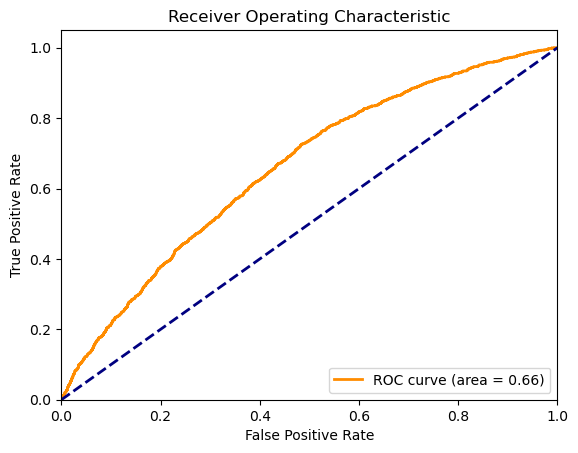

In [434]:
from sklearn.metrics import roc_curve, auc

# Рассчитываем значения для ROC кривой
fpr, tpr, thresholds = roc_curve(y, model.predict(X))

# Вычисляем AUC (Area Under Curve)
roc_auc = auc(fpr, tpr)

# Строим ROC кривую
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

`Примечания`:
- Для оценки параметров логистической регрессии использовался метод максимального правдоподобия
- Была использованна переменная суммы долга и pdn в преобразованном состоянии

`Интерпретация`:
- Анализ выявил, что все изучаемые предикторы обладают статистической значимостью, причём их влияние на модель соответствует логическим предположениям: клиенты, ведущие длительное сотрудничество с кредитной организацией, проявляют меньшую склонность к просрочкам платежей по кредитам. Наблюдается повышение вероятности просрочки платежа при увеличении соотношения долга к доходу. Кроме того, увеличение срока кредитования ассоциируется с более высокой вероятностью просрочки, что может быть обусловлено намерением заемщиков заключить кредитное соглашение на наиболее длительный возможный период. Увеличение суммы долга тоже увеличивает вероятность просрочки, но на 1% уровне значимости коэффициент при этой переменной оказался бы уже не значим.

`Оценка модели`:
- В целом, модель ошибается в 66%
- Precision (точность прогноза): 0.54 говорит о том, что когда модель предсказывает дефолт, она права в 54% случаев.
- Recall (полнота): 0.21 указывает на то, что из всех фактических случаев дефолта модель смогла правильно обнаружить только 21%. Это низкий показатель и может быть критичным, если пропуск дефолтных кредитов имеет серьезные последствия.
- F1 score: 0.30 — это среднее гармоническое точности и полноты. Этот показатель используется, когда нужно учитывать и точность, и полноту, особенно когда они находятся в дисбалансе. В данном случае F1 низкий, что указывает на то, что модель не очень хорошо справляется с задачей на текущих данных или при текущей конфигурации.
- ROC-AUC равен 0.66, что говорит о том, что модель лучше наивной.

`Вывод`:
- Модель значима и показывает значимые коэффициенты, которые верны с точки зрения логики.
- Данная модель оказывается несоответствующей для прогнозирования переменной NPL30, учитывая, что показатели эффективности предсказаний не достигают удовлетворительного уровня. Для этой задачи предлагается использовать методы машинного обучения. 